In [42]:
import torch
import torch.nn as nn
import torch.optim as optimizer
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import copy

In [43]:
#This is the cell for dataset
class circleTasks:
    def __init__(self):
        self.c1=np.random.uniform(-3,3)
        self.c2=np.random.uniform(-3,3)


    def dataset(self,k=10):
        x = np.random.uniform(-5, 5, size=(k, 2))
        dist = np.sqrt((x[:, 0] - self.c1)**2 + (x[:, 1] - self.c2)**2)
        y = (dist < 2.0).astype(np.float32)

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        return x, y

In [44]:
#Here will be the main NN for Maml Intigration
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
          nn.Linear(2, 100),
          nn.ReLU(),
          nn.Linear(100, 100),
          nn.ReLU(),
          nn.Linear(100, 1),
          nn.Sigmoid()
          )
    def forward(self, x, params=None):
        if params is None:
          return self.net(x)
        x = F.linear(x, params['net.0.weight'], params['net.0.bias'])
        x = F.relu(x)
        x = F.linear(x, params['net.2.weight'], params['net.2.bias'])
        x = F.relu(x)
        x = F.linear(x, params['net.4.weight'], params['net.4.bias'])
        x = torch.sigmoid(x)
        return x


In [45]:
#Here will be the code to train MAML model.
def train_maml(beta=0.001,epochs=2000,alpha=0.01,task_per_batch=10):
    model=Model()
    loss_fn=nn.MSELoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=beta)
    meta_losses=[]
    print("Starting MAML Training ...")
    for epoch in range(epochs):
        optimizer.zero_grad()
        meta_loss=0.0
        for _ in range(task_per_batch):
            task = circleTasks()
            x, y = task.dataset()
            x_test, y_test = task.dataset()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            grads = torch.autograd.grad(loss,model.parameters())
            fast_parameters = {}
            for (name, params), grad in zip(model.named_parameters(), grads):
                fast_parameters[name] = params - alpha * grad

        y_pred_test = model(x_test, params=fast_parameters)
        loss_test = loss_fn(y_pred_test, y_test)
        meta_loss += loss_test / task_per_batch
        meta_losses.append(meta_loss.item())
        meta_loss.backward()
        optimizer.step()
        if ((epoch+1) % 100 == 0):
            print(f"Epoch {epoch+1} Meta Loss: {meta_loss.item():.4f}")
    return model,meta_losses

In [46]:
model, loss = train_maml()

Starting MAML Training ...
Epoch 100 Meta Loss: 0.0167
Epoch 200 Meta Loss: 0.0111
Epoch 300 Meta Loss: 0.0165
Epoch 400 Meta Loss: 0.0061
Epoch 500 Meta Loss: 0.0023
Epoch 600 Meta Loss: 0.0034
Epoch 700 Meta Loss: 0.0116
Epoch 800 Meta Loss: 0.0177
Epoch 900 Meta Loss: 0.0198
Epoch 1000 Meta Loss: 0.0100
Epoch 1100 Meta Loss: 0.0048
Epoch 1200 Meta Loss: 0.0081
Epoch 1300 Meta Loss: 0.0053
Epoch 1400 Meta Loss: 0.0010
Epoch 1500 Meta Loss: 0.0067
Epoch 1600 Meta Loss: 0.0155
Epoch 1700 Meta Loss: 0.0086
Epoch 1800 Meta Loss: 0.0021
Epoch 1900 Meta Loss: 0.0116
Epoch 2000 Meta Loss: 0.0028


In [47]:
# Defines the baseline non-meta-learning model and trains it on mixed data from random tasks to serve as a comparison.
class Standard_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(2,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)


In [48]:
def train_standard(epochs=2000, lr=0.01, task_per_epochs=50):
    model = Standard_Model()
    loss_fn = nn.MSELoss()
    loss_list = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("Starting Baseline Training...")
    for epoch in range(epochs):
        epoch_loss = 0.0
        for _ in range(task_per_epochs):
            task = circleTasks()
            x, y = task.dataset()

            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / task_per_epochs
        loss_list.append(avg_loss)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

    return model, loss_list

In [49]:
standard_model,standard_loss=train_standard()

Starting Baseline Training...
Epoch 100 Avg Loss: 0.0894
Epoch 200 Avg Loss: 0.1106
Epoch 300 Avg Loss: 0.1006
Epoch 400 Avg Loss: 0.0874
Epoch 500 Avg Loss: 0.0959
Epoch 600 Avg Loss: 0.1018
Epoch 700 Avg Loss: 0.0892
Epoch 800 Avg Loss: 0.1143
Epoch 900 Avg Loss: 0.1066
Epoch 1000 Avg Loss: 0.1018
Epoch 1100 Avg Loss: 0.0981
Epoch 1200 Avg Loss: 0.0947
Epoch 1300 Avg Loss: 0.0995
Epoch 1400 Avg Loss: 0.0868
Epoch 1500 Avg Loss: 0.0953
Epoch 1600 Avg Loss: 0.1031
Epoch 1700 Avg Loss: 0.1018
Epoch 1800 Avg Loss: 0.1034
Epoch 1900 Avg Loss: 0.0943
Epoch 2000 Avg Loss: 0.0865


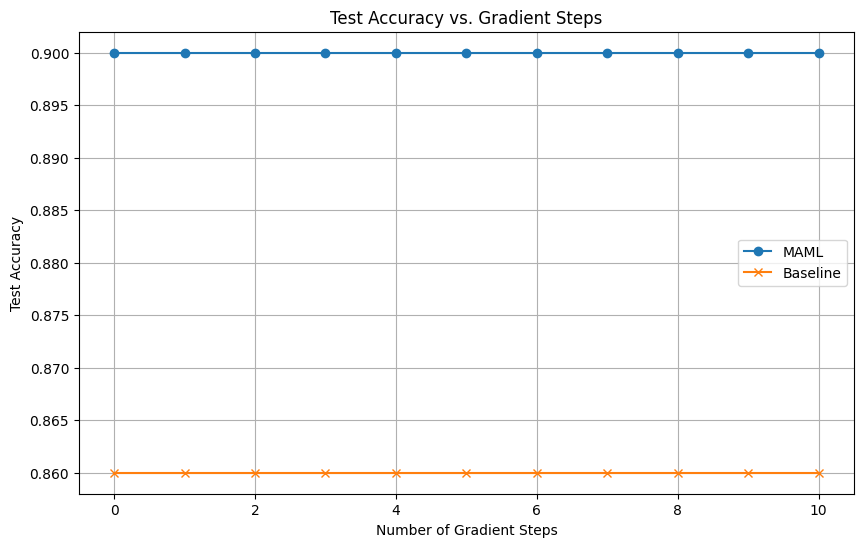

In [50]:
# Compares MAML and Baseline models by fine-tuning on a new task for 10 steps and plotting test accuracy.
def get_accuracy(y_pred, y_true):
    predictions = (y_pred > 0.5).float()
    return (predictions == y_true).float().mean().item()

def evaluate_maml_finetuning(model, task, steps=10, alpha=0.01):
    x_support, y_support = task.dataset(k=10)
    x_query, y_query = task.dataset(k=100)
    acc_history = []

    params = {name: p.clone() for name, p in model.named_parameters()}

    with torch.no_grad():
        y_pred = model(x_query, params=params)
        acc_history.append(get_accuracy(y_pred, y_query))

    for _ in range(steps):
        y_sup_pred = model(x_support, params=params)
        loss = F.mse_loss(y_sup_pred, y_support)
        grads = torch.autograd.grad(loss, params.values())
        params = {name: p - alpha * g for (name, p), g in zip(params.items(), grads)}

        with torch.no_grad():
            y_query_pred = model(x_query, params=params)
            acc_history.append(get_accuracy(y_query_pred, y_query))

    return acc_history

def evaluate_baseline_finetuning(pretrained_model, task, steps=10, lr=0.01):
    model = copy.deepcopy(pretrained_model)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    x_support, y_support = task.dataset(k=10)
    x_query, y_query = task.dataset(k=100)
    acc_history = []

    with torch.no_grad():
        y_pred = model(x_query)
        acc_history.append(get_accuracy(y_pred, y_query))

    for _ in range(steps):
        model.train()
        optimizer.zero_grad()
        y_sup_pred = model(x_support)
        loss = loss_fn(y_sup_pred, y_support)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_query_pred = model(x_query)
            acc_history.append(get_accuracy(y_query_pred, y_query))

    return acc_history

test_task = circleTasks()
maml_acc = evaluate_maml_finetuning(model, test_task, steps=10, alpha=0.01)
baseline_acc = evaluate_baseline_finetuning(standard_model, test_task, steps=10, lr=0.01)

plt.figure(figsize=(10, 6))
plt.plot(range(11), maml_acc, label='MAML', marker='o')
plt.plot(range(11), baseline_acc, label='Baseline', marker='x')
plt.title('Test Accuracy vs. Gradient Steps')
plt.xlabel('Number of Gradient Steps')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

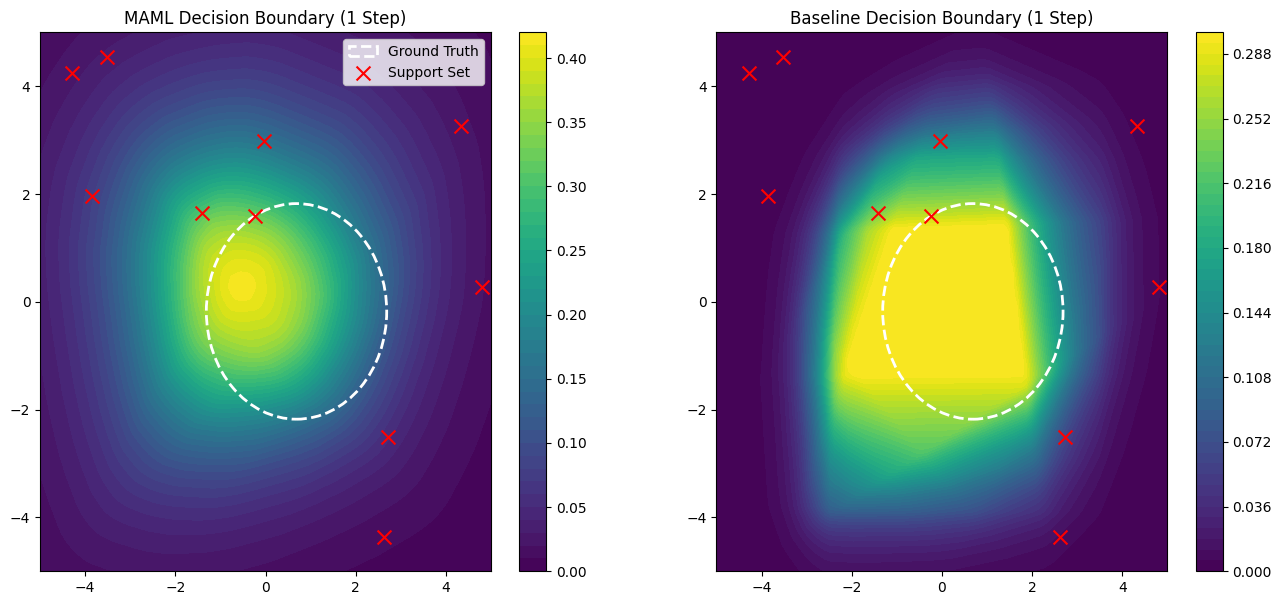

In [55]:
def plot_decision_boundary(maml_model, baseline_model, task):
    x_range = np.linspace(-5, 5, 100)
    y_range = np.linspace(-5, 5, 100)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    cx, cy = task.c1, task.c2
    radius = 2.0

    x_support, y_support = task.dataset(k=10)

    maml_params = {n: p.clone() for n, p in maml_model.named_parameters()}
    y_pred = maml_model(x_support, params=maml_params)
    loss = F.mse_loss(y_pred, y_support)
    grads = torch.autograd.grad(loss, maml_params.values())
    fast_params = {n: p - 0.01 * g for (n, p), g in zip(maml_params.items(), grads)}

    base_model_copy = copy.deepcopy(baseline_model)
    opt = torch.optim.SGD(base_model_copy.parameters(), lr=0.01)
    loss_b = F.mse_loss(base_model_copy(x_support), y_support)
    loss_b.backward()
    opt.step()

    with torch.no_grad():
        maml_probs = maml_model(grid_points, params=fast_params).reshape(xx.shape).numpy()
        base_probs = base_model_copy(grid_points).reshape(xx.shape).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    c1 = axes[0].contourf(xx, yy, maml_probs, levels=50, cmap='viridis')
    axes[0].add_patch(plt.Circle((cx, cy), radius, color='white', fill=False, linestyle='--', linewidth=2, label='Ground Truth'))
    axes[0].scatter(x_support[:,0], x_support[:,1], c='red', marker='x', s=100, label='Support Set')
    axes[0].set_title(f"MAML Decision Boundary (1 Step)")
    axes[0].legend(loc='upper right')
    plt.colorbar(c1, ax=axes[0])

    c2 = axes[1].contourf(xx, yy, base_probs, levels=50, cmap='viridis')
    axes[1].add_patch(plt.Circle((cx, cy), radius, color='white', fill=False, linestyle='--', linewidth=2))
    axes[1].scatter(x_support[:,0], x_support[:,1], c='red', marker='x', s=100)
    axes[1].set_title(f"Baseline Decision Boundary (1 Step)")
    plt.colorbar(c2, ax=axes[1])

    plt.show()

plot_decision_boundary(model, standard_model, circleTasks())